In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.io import loadmat
from torch.distributions import MultivariateNormal, Bernoulli
from cutbayesflow import CutBayesFlow, train_cut_bayes_flow
from cutbayesflow.utils import get_marginal_samples

base_dir = os.getcwd()

# ─────────────────────────────────────────────
# Set seed & parameters
# ─────────────────────────────────────────────
seed = 1
torch.manual_seed(seed)
np.random.seed(seed)

n_samples = 1000
dim_theta = 6  
hidden_dim = 64
num_layers = 2
num_bins = 20
tail_bound = 25.0
learning_rate = 1e-3
epochs = 1000
batch_size = n_samples

# ─────────────────────────────────────────────
# Load data
# ─────────────────────────────────────────────
X_vec = loadmat(os.path.join(base_dir, "simdata", "Xvec.mat"))['mat']
Z_vec = loadmat(os.path.join(base_dir, "simdata", "Zvec.mat"))['mat']
q_mat = loadmat(os.path.join(base_dir, "stage1", "q1.mat"))['mat']

X_t = torch.tensor(X_vec[0, :], dtype=torch.float32).view(1, -1).repeat(n_samples, 1) 
Z_t = torch.tensor(Z_vec[0, :], dtype=torch.float32).view(1, -1).repeat(n_samples, 1) 
q_t = torch.tensor(q_mat[:, :, 1:], dtype=torch.float32)  
q_flat = q_t.reshape(n_samples, -1) 
p_eta = q_flat.shape[1]

data_D2 = {
    "X": X_t,     
    "Z": Z_t,     
    "q": q_t      
}

# ─────────────────────────────────────────────
# Define likelihood log-probability function
# ─────────────────────────────────────────────
def likelihood_log_prob_fn(theta, eta, data):
    """
    log p(Z | theta, q, X) where Z ~ Bernoulli(sigmoid(beta0 + beta1*X + q*gamma))
    theta: [N, dim_theta], eta: [N, p_eta]
    data: dict with 'X', 'Z', and 'q'
    """
    X, Z, q = data["X"], data["Z"], data["q"]
    N = theta.shape[0]
    beta0 = theta[:, 0].unsqueeze(1)  
    beta1 = theta[:, 1].unsqueeze(1)  
    gamma = theta[:, 2:].unsqueeze(1)  

    sum_q_gamma = (q * gamma).sum(dim=2)  
    logits = beta0 + beta1 * X + sum_q_gamma  
    probs = torch.sigmoid(logits)

    bernoulli = Bernoulli(probs)
    log_likelihood = bernoulli.log_prob(Z).sum(dim=1)  
    return log_likelihood

# ─────────────────────────────────────────────
# Define prior log-probability function
# ─────────────────────────────────────────────
def prior_log_prob_fn(theta):
    """
    Multivariate Normal prior over theta ~ N(0, diag([800, 50, 50, 50, 50, 50]))
    """
    prior_std = torch.sqrt(torch.tensor([800.] + [50.] * 5, dtype=torch.float32))
    scale_tril = torch.diag(prior_std)
    dist = MultivariateNormal(torch.zeros(dim_theta), scale_tril=scale_tril)
    return dist.log_prob(theta)

# ─────────────────────────────────────────────
# Initialize NeVI-Cut model
# ─────────────────────────────────────────────
model = CutBayesFlow(
    prior_log_prob_fn=prior_log_prob_fn,
    likelihood_log_prob_fn=likelihood_log_prob_fn,
    eta_dim=p_eta,
    theta_dim=dim_theta,
    num_layers=num_layers,
    hidden_features=hidden_dim,
    num_bins=num_bins,
    tail_bound=tail_bound
)

# ─────────────────────────────────────────────
# Train model
# ─────────────────────────────────────────────
print("Training NeVI-Cut on propensity score simulation...")
loss_history = train_cut_bayes_flow(
    model=model,
    eta_samples=q_flat,
    data_D2=data_D2,  
    epochs=epochs,
    lr=learning_rate,
    patience=200,
    seed=1010,
    verbose=100  
)


Training NeVI-Cut on propensity score simulation...
Using batch_size=1000 (full-batch: True)
Step     0 | Loss: 1807.687378 | LR: 1.00e-03
Step   100 | Loss: 670.369568 | LR: 1.00e-03
Step   200 | Loss: 669.248108 | LR: 1.00e-03
Step   300 | Loss: 668.013855 | LR: 1.00e-03
Step   400 | Loss: 668.324036 | LR: 1.00e-03
Epoch 00472: reducing learning rate of group 0 to 5.0000e-04.
Step   500 | Loss: 668.005127 | LR: 5.00e-04
Step   600 | Loss: 668.446106 | LR: 5.00e-04
Epoch 00689: reducing learning rate of group 0 to 2.5000e-04.
Step   700 | Loss: 667.586243 | LR: 2.50e-04
Step   800 | Loss: 667.610229 | LR: 2.50e-04
Epoch 00901: reducing learning rate of group 0 to 1.2500e-04.
Step   900 | Loss: 667.595642 | LR: 1.25e-04
Step   999 | Loss: 667.640076 | LR: 1.25e-04


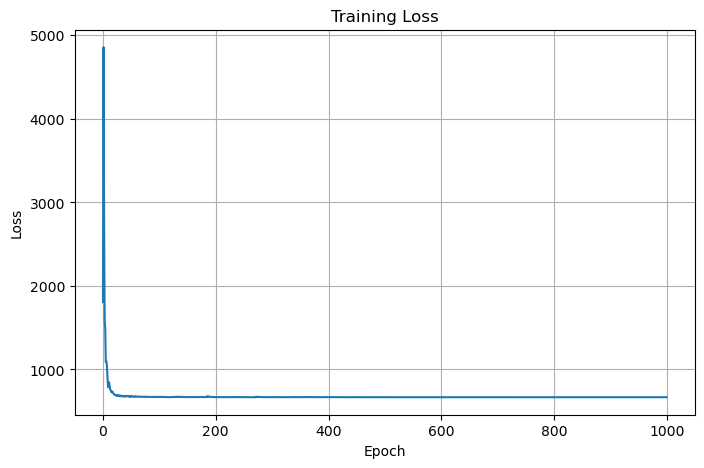

In [2]:
# ─────────────────────────────────────────────
# Plot training loss
# ─────────────────────────────────────────────
plt.figure(figsize=(8, 5))
plt.plot(loss_history)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()



Generated 100/1000 samples
Generated 200/1000 samples
Generated 300/1000 samples
Generated 400/1000 samples
Generated 500/1000 samples
Generated 600/1000 samples
Generated 700/1000 samples
Generated 800/1000 samples
Generated 900/1000 samples
Generated 1000/1000 samples


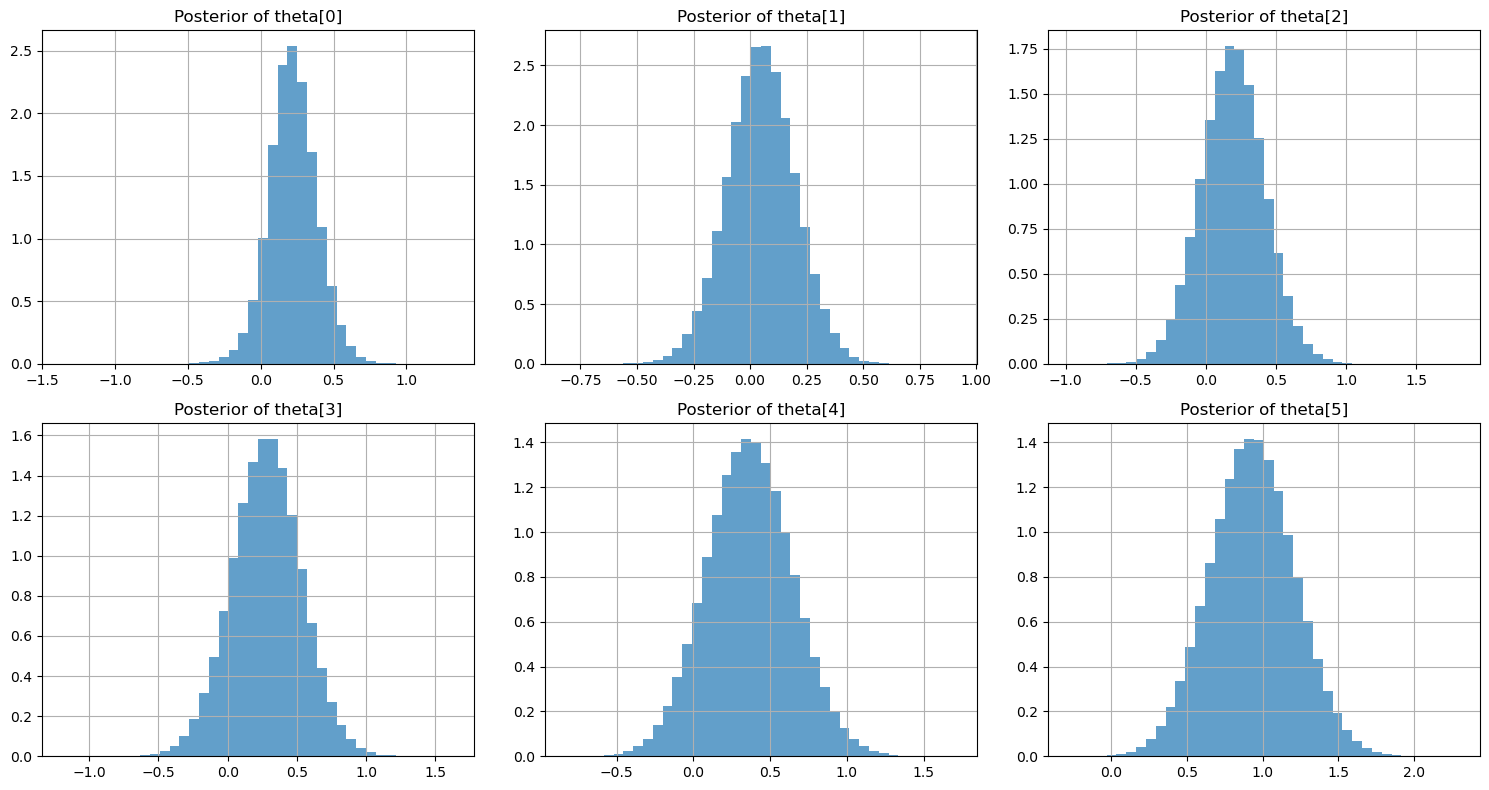

In [3]:
# ─────────────────────────────────────────────
# Generate marginal samples of theta
# ─────────────────────────────────────────────

n_iterations = 1000

theta_samples_q = get_marginal_samples(model, q_flat, n_iterations=n_iterations)
theta_samples_q_flat = theta_samples_q.reshape(-1, dim_theta).cpu().numpy()

# Plot histograms for each parameter theta_k
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()
for i in range(dim_theta):
    axes[i].hist(theta_samples_q_flat[:, i], bins=40, density=True, alpha=0.7)
    axes[i].set_title(f"Posterior of theta[{i}]")
    axes[i].grid(True)
plt.tight_layout()
plt.show()
